# Assignment 5: Continous-time models
## [Scientific Computing with Python](https://scicompy.yoavram.com/)
## Yoav Ram

In [230]:
from datetime import datetime

%matplotlib inline
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)

import scipy.stats
import scipy.optimize
from scipy.integrate import solve_ivp
from functools import partial
from scipy.optimize import curve_fit

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. *But*, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible to "lose your loops".
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment 5"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

In [91]:
import warnings
warnings.filterwarnings('ignore')

# Ex 1: Generalized logistic model

Here is the growth curve data that we saw in the lecture: the density of a bacterial culture in 94 samples across time.

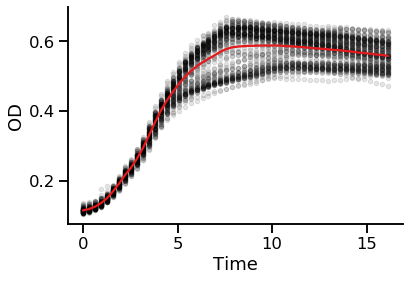

In [92]:
###
data = np.load('../data/Yoav_311214c_only_OD.npz')
t, N, t_agg, N_agg = data['t'], data['N'], data['t_agg'], data['N_agg']

plt.plot(t, N, '.k', alpha=0.1)
plt.plot(t_agg, N_agg, '-', color=red)
plt.xlabel('Time')
plt.ylabel('OD')
sns.despine();

The [generalized logistic model](https://en.wikipedia.org/wiki/Generalised_logistic_function) has an additional parameter $\nu$ so that the curve doesn't have to be symmetric, that is, the time to get from $N(0)$ to $K/2$ can be longer/shorter than the time to get from $K/2$ to $K$.

$$
\frac{d N}{d t}= r N \bigg(1 - \bigg(\frac{N}{K}\bigg)^{\nu}\bigg)
$$

The other parameters are the same as the logistic model.

**Fit the logistic and the generalized logistic model to the data** and print the model parameters with their confidence intervals (i.e. estimated standard deviations).

$$
N(t) = \frac{K}{1 - \Big( 1 - \frac{K}{N(0)} \Big) e^{-r t} }
$$

In [93]:
def logistic(t, N0, K, r): ###
    # As we saw in class
    return K / (1 - (1 - K/N0) * np.exp(-r * t))

def generalized_logistic(t, N0, K, r, ν): ###
     return (K / ((1 - (1 - (K / N0)** ν) * np.exp(-r * ν * t))**(1/ν)))




**Plot the fitted curves together with the data.**

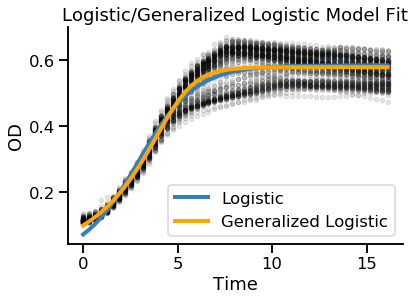

In [98]:
# Logistic approach

# Provided the simulated data. We will get back an estimate of the model parameters
params_l, cov_l = curve_fit(f=logistic, xdata=t_agg, ydata=N_agg, p0=(N_agg.min(), N_agg.max(), 1))
# Unpacking parameters
N0, K, r = params_l
N_l = logistic(t_agg, N0, K, r)


# Generalized Logistic approach

# Provided the simulated data. We will get back an estimate of the model parameters
params_gl, cov_gl = curve_fit(f=generalized_logistic, xdata=t_agg, ydata=N_agg, p0=(N_agg.min(), N_agg.max(), 1, 1))
# Unpacking parameters
N0, K, r, v = params_gl
N_gl = generalized_logistic(t_agg, N0, K, r, v)

# Plotting 
plt.plot(t, N, '.k', alpha=0.1)
plt.plot(t_agg, N_l, '-k', color=blue,lw=4, label='Logistic')
plt.plot(t_agg, N_gl, '-k', color="orange", lw=4, label='Generalized Logistic')
plt.xlabel('Time')
plt.ylabel('OD')
plt.title('Logistic/Generalized Logistic Model Fit')
plt.legend()
sns.despine()

In [99]:
param_l_std = np.diag(cov_l)**0.5
param_gl_std = np.diag(cov_gl)**0.5

print('Logistic Model Parameters:')
print('N0 = {:.3f} ± {:.3f}'.format(params_l[0],param_l_std[0]))
print('K  = {:.3f} ± {:.3f}'.format(params_l[1],param_l_std[1]))
print('r  = {:.3f} ± {:.3f}'.format(params_l[2],param_l_std[2]))

print('Generalized Logistic Model Parameters:')
print('N0 = {:.3f} ± {:.3f}'.format(params_gl[0],param_gl_std[0]))
print('K  = {:.3f} ± {:.3f}'.format(params_gl[1],param_gl_std[1]))
print('r  = {:.3f} ± {:.3f}'.format(params_gl[2],param_gl_std[2]))
print('ν  = {:.3f} ± {:.3f}'.format(params_gl[3],param_gl_std[3]))


Logistic Model Parameters:
N0 = 0.073 ± 0.004
K  = 0.585 ± 0.003
r  = 0.670 ± 0.022
Generalized Logistic Model Parameters:
N0 = 0.100 ± 0.004
K  = 0.579 ± 0.002
r  = 0.357 ± 0.016
ν  = 3.252 ± 0.379


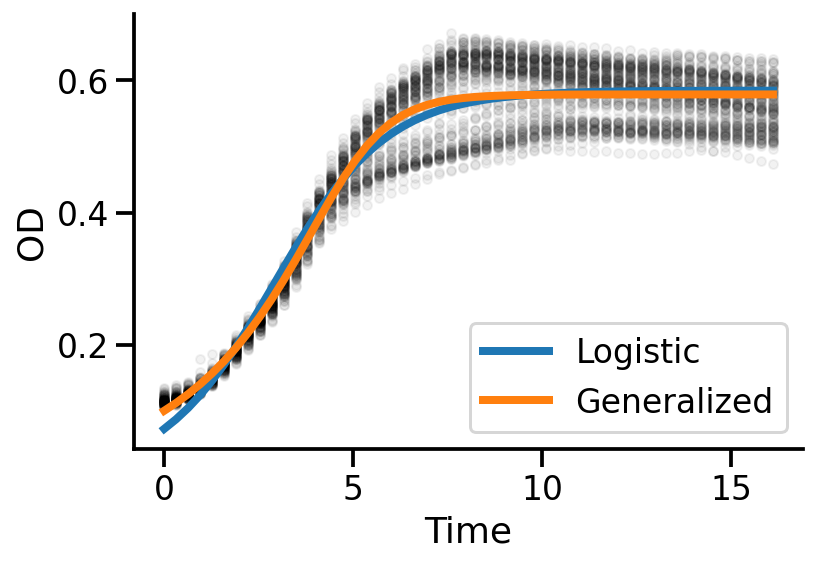

 Which is a better fit? The logistic model or the generalized logistic?

These models are nested: the logistic model is equivalent to the generalized model with $\nu=1$. 

Therefore, we can use the likelihood ratio test (or a regerssion [F-test](https://en.wikipedia.org/wiki/F-test#Regression_problems)) to select between them.

We check if the evidence (data) supports rejecting the null model (logisitc model) in favor of the alternative model (generalized logistic model) despite the additional parameter ($\nu$) of the alternative model.

**Implement the likelihood ratio test** and print the result.

Let the likelihood ratio test be defined by:
$$F={\frac  {\left({\frac  {{\text{RSS}}_{0}-{\text{RSS}}_{1}}{p_{1}-p_{0}}}\right)}{\left({\frac  {{\text{RSS}}_{1}}{n-p_{1}}}\right)}}$$

In [108]:
# We define the following parameters
n = len(t)
p0 = len(params_l)
p1 = len(params_gl)

rss0 = np.sum(pow((N_agg - N_l),2))
rss1 = np.sum(pow((N_agg - N_gl),2))

F_num = (rss0 - rss1) / (p1 - p0)
F_den = rss1 / (n - p1)

F = F_num / F_den
pvalue = scipy.stats.f(p1 - p0, n - p1).sf(F)

print("F-statistic: {:.2f}".format(F)) ###
print("Likelihood-ratio test P-value = {}".format(pvalue)) ###
print("Generalized logistic model is favored?", pvalue < 0.05) ###

# Expected Results:
# F-statistic: 10339.27
# Likelihood-ratio test P-value = 0.0
# Generalized logistic model is favored? True

F-statistic: 10339.27
Likelihood-ratio test P-value = 0.0
Generalized logistic model is favored? True


# Ex 2: Fit Lotka-Volterra competition models to experimental data

In this section we will analyse competitions between two strains of bacteria.

Let's start by loading some data.

## Data

You might need to do a `git pull` to get the data.

In [231]:
###
df = pd.read_csv('../data/flow_df_2015-11-18.csv')
df = df[['Strain','date','hour','freq_mean']]
df = df.rename(columns=dict(Strain='strain', freq_mean='frequency'))
df.head()

,strain,date,hour,frequency
0,Green,11/18/2015,10:30,0.432883
1,Red,11/18/2015,10:30,0.567117
2,Green,11/18/2015,11:25,0.386035
3,Red,11/18/2015,11:25,0.613965
4,Green,11/18/2015,12:10,0.337225


The data shows results of competitions between two bacteria strains, one marked as _Green_ and the other as _Red_.
Approximately every hour, a sample was taken from the tube in which the bacteria were competing. The sample was then processed using flow cytometry to count the number of cells with either a green or a red fluorescent protein (GFP or RFP). Then, the frequencies of the green and red cells were calculated by dividing the number of cells by the total number of cells (i.e. frequency of green = number of green / (number of green + number of red)).

The frequency of each strain was recored at each time point, but times are encoded as dates and hours.

**Create a new column called `time`** that has the number of hours passed since the start of the experiment.
Then you can drop the `date` and `hour` columns.

Tips: you can use `datetime.strptime`.

In [232]:
df['timestamp'] = df['date'] + ' ' + df['hour']
df['timestamp'] = df.apply(lambda row: datetime.strptime(row['timestamp'], '%m/%d/%Y %H:%M'), axis=1)

min_time = df['timestamp'].min()
df['timestamp'] = df.apply(lambda row: row['timestamp']-min_time, axis=1)


df.drop(['date', 'hour'], axis=1, inplace=True)
df

,strain,frequency,timestamp
0,Green,0.432883,00:00:00
1,Red,0.567117,00:00:00
2,Green,0.386035,00:55:00
3,Red,0.613965,00:55:00
4,Green,0.337225,01:40:00
5,Red,0.662775,01:40:00
6,Green,0.222792,02:45:00
7,Red,0.777208,02:45:00
8,Green,0.178563,03:40:00
9,Red,0.821437,03:40:00


**Plot the frequencies of the two strains over time**.
Make sure you use the correct colors, labels, etc.

In [233]:
# Splitting into two classes
green_df = df[df['strain'] == 'Green']
red_df = df[df['strain'] == 'Red']

# print(green_df)
# print(red_df)

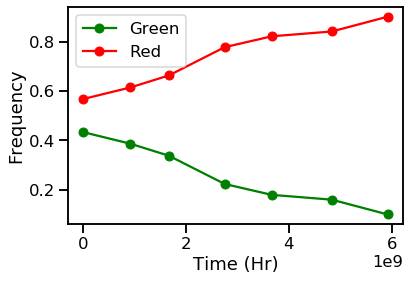

In [243]:
seconds_in_hour = 60 * 60 #seconds*min

plt.figure()

plt.plot(green_df['timestamp']/seconds_in_hour, green_df['frequency'], '-o', label = 'Green',color='green')
plt.plot(red_df['timestamp']/seconds_in_hour, red_df['frequency'], '-o', label = 'Red',color='red')

plt.xlabel('Time (Hr)')
plt.ylabel('Frequency')

# plt.ylim((0,1)) #I dont know why this throws an erro

plt.legend()
plt.show()

To model competitions between two strains (or species) we will use the classical [competitive Lotka–Volterra equations](https://en.wikipedia.org/wiki/Competitive_Lotka–Volterra_equations) (not to be confused with the predator-prey Lotka-Volterra equations).

This model describes the change in the population sizes of the two strains, $x_1$ and $x_2$.

$$
\frac{dx_1}{dt} = r_1 x_1 \Big(1 - \bigg(\frac{x_1 + \alpha_2 x_2}{K_1}\bigg)\Big) \\
\frac{dx_2}{dt} = r_2 x_2 \Big(1 - \bigg(\frac{\alpha_1 x_1 + x_2}{K_2}\bigg)\Big)
$$

where $r_i$ and $K_i$ are the per-capita growth rate and maximum population size of strain $i$, and $\alpha_1$ and $\alpha_2$ are the *competition coefficients*.

Note the similarity between this model and the single-population logistic growth model; here, the growth-limiting term accounts for both strains, rather than just one.

The competition coefficients account for the relative effect individuals of strain $i$ on growth of individuals of strain $j$ compared to other individuals of strain $i$.
Specifically, different $\alpha_i$ values can be interpreted as [competition, parasitism, or even charity](https://en.wikipedia.org/wiki/Biological_interaction#Symbiosis:_long-term_interactions) (see these concepts explained by [Ernie and Bert](https://www.dropbox.com/s/gga4ggpewjus5tq/SesameSt.pptx?dl=0)).

In the following, we will 
1. fit the above model (LV6) to the data,
1. fit a nested, simpler, model (LV4) to the data, in which $\alpha_1=\alpha_2=1$; that is, strain $i$ has the same effect on strain $j$ as it does on itself.
1. select the best model out of the two.

The names LV6 and LV4 are due to the model name (Lotka-Volterra) and the number of free parameters: $r_1, r_2, K_1, K_2, \alpha_1, \alpha_2$ in LV6, and $r_1, r_2, K_1, K_2$ in LV4.

**Write a function called `LV6_ode(t, x, ...)`** that takes the time `t`, an array `x` of populations sizes at time `t`, and the rest of the model parameters, and returns an array of the derivatives of `x` with respect to `t`; $\bigg(\frac{dx_1}{dt}, \frac{dx_2}{dt}\bigg)$.

**Write another function called `LV4_ode(t, x, ...)`** that performs the same operation, but with the competition parameters set to 1.

$$
\frac{dx_1}{dt} = r_1 x_1 \Big(1 - \bigg(\frac{x_1 + \alpha_2 x_2}{K_1}\bigg)\Big) \\
\frac{dx_2}{dt} = r_2 x_2 \Big(1 - \bigg(\frac{\alpha_1 x_1 + x_2}{K_2}\bigg)\Big)
$$

In [270]:
def LV6_ode(t, x, *params): ### 
    # Unpacking parameters
    r1, r2, k1, k2, alpha1, alpha2 = params
    x1, x2 = x
    
    # Following provided func
    dx1 = r1 * x1 * (1 - (x1 + alpha2 * x2) / k1 )
    dx2 = r2 * x2 * (1 - (alpha1 * x1 + x2) / k2 )
    
    return np.array([dx1,dx2])
    
        
def LV4_ode(t, x, *params): ### 
    return LV6_ode(t, x, *(params + (1,1)))


**Write a function called `model(ode, t, xinit, ...)`** that takes an ODE function `ode` (such as `LV6_ode` or `LV4_ode`), time points `t`, initial values `xinit` for the population sizes, and any required parameters values.
The function then integrates the ODE and returns the population *frequencies* at the time points `t`.

Then **run and plot** an example dynamics for both LV6 and LV4.
Try to choose parameters values ($r_i, K_i, \alpha_i$) that demonstrate the effect of competition on the dynamics (i.e. such that LV6 and LV4 produce distinct dynamics).

In [277]:
def model(ode, t, xinit, *params): ###
    result = scipy.integrate.odeint(ode, xinit, t, args=params, tfirst=True)
    pop = result.sum(axis=1)
#     print(result)
#     print(pop)
    return result/pop[:,None]
    
    
LV4 = partial(model, LV4_ode) ###
LV6 = partial(model, LV6_ode) ###

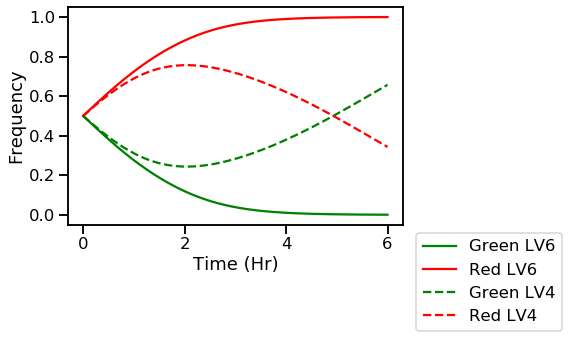

In [364]:
# setting up parameters
t = np.linspace(0, 6, 1000)
r1 = 1
r2 = 2 
k1 = 2500
k2 = 1500
alpha1 = 1
alpha2 = 4
x = [50, 50]

#         t,  x  *params -----------------------
lv_6 = LV6(t, x, r1, r2, k1, k2, alpha1, alpha2)
lv_4 = LV4(t, x, r1, r2, k1, k2)

plt.plot(t, lv_6[:,0], color='green',ls='-', label='Green LV6')
plt.plot(t, lv_6[:,1], color='red', ls='-', label='Red LV6')
plt.plot(t, lv_4[:,0], color='green',ls='--', label='Green LV4')
plt.plot(t, lv_4[:,1], color='red',ls='--', label='Red LV4')

plt.xlabel("Time (Hr)")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.5, 0))

plt.show()

**Fit both models to the data**.

You can use MLE or MCMC, what ever you prefer.

Think:
- what should be a good-enough loss function, and how you can minimize it?
- what should be the initial population sizes in `model`? 
- what should be the time points?

After fitting the two models, **print and plot a summary** of the fitting for each model:
- print the estimated parameters with some confidence interval,
- plot the data together with the fitted model.

Make sure the print messages and the plots are as clear and illustrative as possible.

In [370]:
def mle_loss(params, ode, xinit, x, y):
    result = model(ode, x, xinit, *params)
    y = np.row_stack((y[::2], y[1::2]))
    print(y)
    return (pow(result.T - y),2).sum()

In [381]:
t = red_df['timestamp'].apply(lambda row: row.seconds/seconds_in_hour)
# print(t)

lv4 = scipy.optimize.fmin(mle_loss, [.3, .05, 500, 200], args=(LV4_ode, x, t, df.frequency))
lv6 = scipy.optimize.fmin(mle_loss, [.3, .05, 500, 200, .5, .5], args=(LV6_ode, x, t, df.frequency))


[[0.43288344 0.38603524 0.33722524 0.22279179 0.17856324 0.15908126
  0.09931414]
 [0.56711656 0.61396476 0.66277476 0.77720821 0.82143676 0.84091874
  0.90068586]]


TypeError: pow expected at least 2 arguments, got 1

In [ ]:
print('\n LV6 loss: {:.6f} \n r= {:.4f}, {:.4f}; K = {:.4f}, {:.4f}'.format(*θ_hat_lv6))
print('\n LV4 loss: \n r= {:.4f}, {:.4f}; K = {:.4f}, {:.4f}'.format(*θ_hat_lv4))
# Expected Format:
# LV6 loss: XXXXXX
# r=XXXX, XXXX; K=XXXX, XXXX

# LV4 loss: XXXXXX
# r=XXXX, XXXX; K=XXXX, XXXX

LV6 loss: XXXXXX
r=XXXX, XXXX; K=XXXX, XXXX

LV4 loss: XXXXXX
r=XXXX, XXXX; K=XXXX, XXXX


Since it may be difficult to decide which model is better based on the summaries and plots above, we perform model selection to select one of the models and answer the question:  _can the nested model LV4 be rejected in favor of the full model LV6?_

**Print and plot the steps to perform model selection**, and finish with a clear statement answering the question above.

Note: You can use the likelihood-ratio test or any other method; if you chose to perform Bayesian inference in the previous steps, you can use a measure such as AIC or WAIC.

**End of file**